In [31]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

sys.path.append("../mio/features")
sys.path.append("../mio/utilities/")
sys.path.append("../mio/utilities/summarystats")
sys.path.append("../mio/data")
sys.path.append("../mio/designs")
from mio.visualize import interactive_scatter
from mio.data.dataset import DataSet
from gillespy2.solvers.cpp import SSACSolver
from gillespy2.solvers.stochkit import StochKitSolver
import gillespy2
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
model_doc = gillespy2.StochMLDocument.from_file("/home/wrede/windows_projects/psa/psa/examples/vilar_oscillator.xml")

In [8]:
model = model_doc.to_model("Vilar")

In [34]:
def set_model_parameters(model, params):
    """ params - array, needs to have the same order as model.listOfParameters """
    for e, (pname, p) in enumerate(model.listOfParameters.items()):
        model.get_parameter(pname).set_expression(params[e])
    return model


def simulator(param):
    
    model = set_model_parameters(model, param)
    num_timepoints = 400
    model.tspan = np.linspace(0, 400, num_timepoints)
    num_trajectories = 10
    res = model.run(solver=StochKitSolver, show_labels=False, number_of_trajectories=num_trajectories)
    
    return np.array(res)
    
    

In [29]:
import sys
sys.path.append("../mio/features")
sys.path.append("../mio/utilities/")
sys.path.append("../mio/utilities/summarystats")
from summary_base import SummaryBase
from feature_extraction import generate_tsfresh_features
from tsfresh.feature_extraction import MinimalFCParameters


# Class definition: SummariesEnsemble
class SummariesTSFRESH(SummaryBase):
    """
    An ensemble of different statistics from TSFRESH
    """

    def __init__(self):
        self.name = 'SummariesTSFRESH'
        self.features = None
        super(SummariesTSFRESH, self).__init__(self.name)

    def compute(self, data, features=MinimalFCParameters()):
        self.features = features
        feature_values = generate_tsfresh_features(data, features)
        # ToDo: Check for NaNs
        return feature_values


In [36]:
num_timepoints = 400
model.tspan = np.linspace(0, 400, num_timepoints)
num_trajectories = 10
res = model.run(solver=StochKitSolver, show_labels=False, number_of_trajectories=num_trajectories)
res = np.array(res)


In [92]:
f = SummariesTSFRESH()
data = DataSet(name='tsfresh')

data.configurations['listOfParameters'] = list(model.listOfParameters.keys())
data.configurations['listOfSpecies'] = list(model.listOfSpecies.keys())

In [93]:
params = [[float(x.expression) for x in list(model.get_all_parameters().values())]]*len(res)
params = np.array(params)
labels = np.ones(len(res))*-1
features = f.compute(res)

data.set_data(inputs=params, targets=labels, time_series=res, summary_stats=features) 

In [94]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(data.s)

now visualizing scatterlplot...


<IPython.core.display.Javascript object>


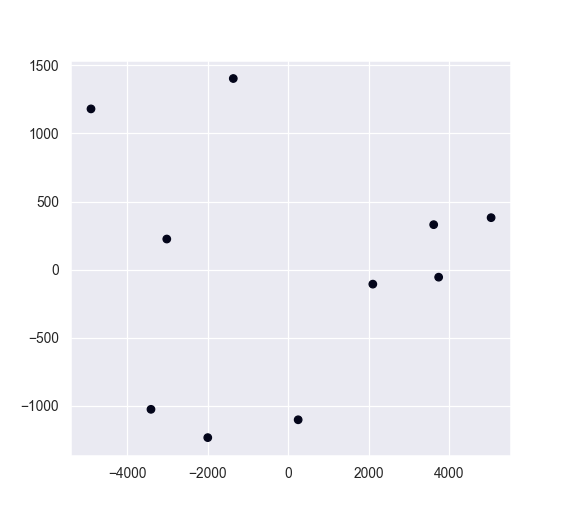

Button(description='Clear all', style=ButtonStyle())

scatterplot done


In [95]:
interactive_scatter.interative_scatter(data=pca_data, labels=data.y)

In [5]:
from ipywidgets import widgets
from IPython.display import display

In [6]:
test = widgets.Text()
display(test)

Text(value='')

In [8]:
def f(x):
    print(x)
widgets.interact(f, x=10)

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

<function __main__.f(x)>

In [11]:
type(iris_data)

sklearn.utils.Bunch

In [17]:
import numpy as np
np.concatenate((np.ndarray([]),np.ndarray([[1,2],[2,3]])))

TypeError: 'list' object cannot be interpreted as an integer

In [23]:
np.empty((2,2,2)).shape[1:]

(2, 2)